In [81]:
import sys

sys.path.append('../poligrain/src')
sys.path.append('../mergeplg/src')

import poligrain as plg
import mergeplg as mrg

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Create synthetic example data

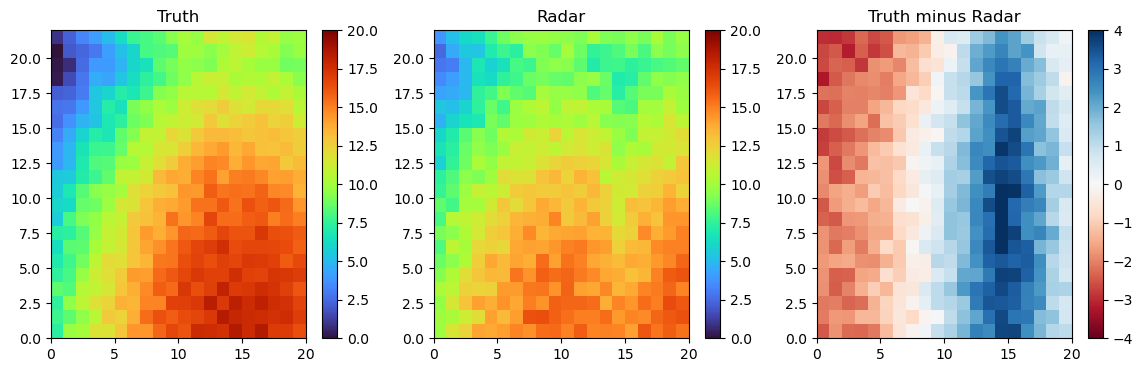

In [76]:
# grid axes
x = np.arange(0, 20)
y = np.arange(20, 42)
x_grid, y_grid = np.meshgrid(x, y)
#grid_coords = np.dstack((x_grid.flatten(), y_grid.flatten()))[0]

num_obs = 5

np.meshgrid

np.random.seed(13196840)

# Synthetic true rainfall
truth = (
    np.abs(10.0 * np.sin(0.11 * x_grid))
    + np.abs(8.0 * np.sin(0.08 * y_grid))
    )
truth = truth + 0.8 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)

# Creating radar data by perturbing truth with multiplicative and
radar = truth.copy()
radar = 1.0 * truth + 0.5 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)
radar = (
    radar 
    + np.abs(6 * np.cos(0.11 * x_grid))
    - np.abs(3 * np.sin(0.06  * y_grid))
)
radar = radar - 1
radar[radar < 0.0] = 0.0


vmin, vmax = 0, 20
cmap = 'turbo'
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].set_title('Truth')
pc = axs[0].pcolormesh(truth, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[1].set_title('Radar')
pc = axs[1].pcolormesh(radar, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[2].set_title('Truth minus Radar')
pc = axs[2].pcolormesh(truth - radar, vmin=vmax * -0.2, vmax=vmax * 0.2, cmap='RdBu')
plt.colorbar(pc)



In [108]:
ds_radar = xr.Dataset(
    data_vars={
        'R_radar': ( ['y', 'x'], radar),
        'R_true': (['y',  'x'], truth),
    },
    coords={
        'xs': (['y', 'x'], x_grid),
        'ys':  (['y',   'x'], y_grid),
    },
)

# hack, for now...
ds_radar.coords['lon'] = ds_radar.xs
ds_radar.coords['lat'] = ds_radar.ys


<Axes: xlabel='xs', ylabel='ys'>

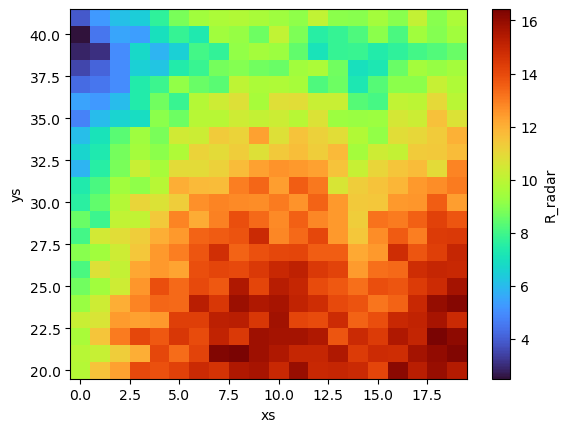

In [109]:
plg.plot_map.plot_plg(da_grid=ds_radar.R_radar, use_lon_lat=False)

In [128]:
ds_gauges = xr.Dataset(
    data_vars={
        'R_init': (['id'], [0, 0, 0, 0]),
    },
    coords={
        'x': (('id'), [2, 16, 3, 6]),
        'y':  (['id'], [22, 25, 33, 26]),
    },
)

# hack, for now
ds_gauges.coords['lon'] = ds_gauges.x
ds_gauges.coords['lat'] = ds_gauges.y

In [147]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
)

ds_gauges['R'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_true.expand_dims('time'),
    da_point_data=ds_gauges.R_init.expand_dims('time'),
)

<Axes: xlabel='xs', ylabel='ys'>

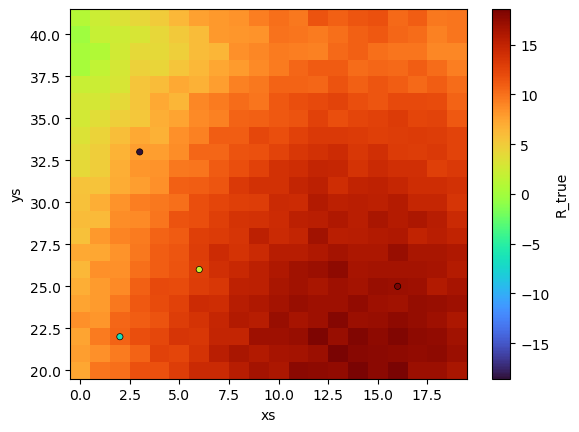

In [149]:
plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R.isel(time=0),
    use_lon_lat=False,
)

In [3]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

In [10]:
idw_interpolator = mrg.interpolate.InterpolateIDW()

idw_interpolator.interpolate(
            da_grid=ds_rad.isel(time=10).R,
            da_cml=ds_cmls.isel(time=10).R,
            nnear=9,
        )

AttributeError: 'DataArray' object has no attribute 'site_0_x'